<a href="https://colab.research.google.com/github/lcipolina/art/blob/main/prompts/clip_Interrogator_w_checkpointing%2Badjectives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CLIP Interrogator + CLIP checkpointing & 14000+ Adjectives by [@AlexanderRedde3](https://twitter.com/AlexanderRedde3) 

## Based _Heavily_ on CLIP Interrogator by [@pharmapsychotic](https://twitter.com/pharmapsychotic) 

[Link to their version here](https://colab.research.google.com/github/pharmapsychotic/clip-interrogator/blob/main/clip_interrogator.ipynb)

<br>

*Pharmapsychotic's intro description:*
<br>

What do the different OpenAI CLIP models see in an image? What might be a good text prompt to create similar images using CLIP guided diffusion or another text to image model? The CLIP Interrogator is here to get you answers!

<br>

If this notebook is helpful to you please consider buying pharmapsychotic a coffee via [ko-fi](https://ko-fi.com/pharmapsychotic) or following them on [twitter](https://twitter.com/pharmapsychotic) for more cool Ai stuff. 🙂

And if you're looking for more Ai art tools check out their [Ai generative art tools list](https://pharmapsychotic.com/tools.html).


In [1]:
#@title Check GPU
#@markdown ### If you want to use ViT-L/14@336px, you need at least 16GB of ram (will work on P100) 
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8e6b4f8a-f290-91cf-54a5-e5698e5f96b9)


In [2]:
#@title Install Requirements
!pip3 install ftfy regex tqdm transformers==4.15.0 timm==0.4.12 fairscale==0.4.4 clip open-clip-torch pydash pydantic typing_extensions
!rm -rf interrogator
!git clone https://github.com/aredden/interrogator
!git clone https://github.com/salesforce/BLIP
!cp interrogator/* . -r
!cp BLIP/configs configs -r

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 3.4 MB 60.4 MB/s 
     |████████████████████████████████| 376 kB 44.9 MB/s 
     |████████████████████████████████| 235 kB 68.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.4 MB 56.8 MB/s 
     |████████████████████████████████| 84 kB 4.5 MB/s 
     |████████████████████████████████| 3.3 MB 55.7 MB/s 
     |████████████████████████████████| 120 kB 77.3 MB/s 
     |████████████████████████████████| 880 kB 58.6 MB/s 
  Created wheel for fairscale: filename=fairscale-0.4.4-py3-none-any.whl size=292864 sha256=7a54afd5a70d993e15fffbdf8ab6fc93d564c42f7f1cb176be5237f365d60ddf
  Stored in directory: /root/.cache/pip/wheels/7e/01/9d/e

In [3]:
from PIL import Image
import requests,io,sys

#@markdown ### If you are planning to use ViT-L/14@336px, make sure to use BLIP base.
#@markdown Using BLIP large with CLIP 336px will use more than 16GB of vram. 
from interogator import ClipOptions, Interrogator, RuntimeConfig, load_blip
args = RuntimeConfig()
import ipywidgets as widgets
from IPython.display import display, clear_output
args.in_colab = True  # @param{type:"boolean"}
args.blip_model_size = "base"  # @param ["large","base"]
#@markdown Run this cell to show the CLIP multiselect box. 
#@markdown <br> To select more than 1 clip model, CTRL+Click each clip model, and then press the 'Choose' button. 
def on_button_click(b):
    global handle
    clip_options = []
    s = select_field.get_state()
    for index in s["index"]:
        clip_options.append(opts[index])
    clear_output()
    print(f"Using models {[c[0] for c in clip_options]}")
    args.clip_models = clip_options

opts = [v for k, v in ClipOptions.dict().items()]
if args.in_colab:
    output = widgets.Output()
    with output:
      output.clear_output()
    select_field = widgets.SelectMultiple(
        description="Choose Clip Models",
        options=[(k,v) for k, v in ClipOptions.dict().items()],
    )
    button = widgets.Button(description="Choose!")
    button.on_click(on_button_click)
    display(select_field, button, output)



Using models ['ViT-L-14-336']


load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model*_base_caption.pth


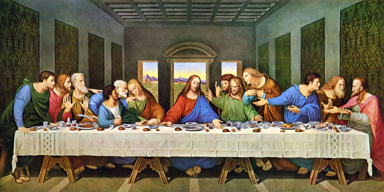

Interrogating with ('ViT-L-14-336', 'openai')...


,Model,Medium,Artist,Trending,Movement,Flavors
0,"(ViT-L-14-336, openai)",a minimalist painting (18.9%),by Leonardo da Vinci (21.8%),pixiv contest winner (17.8%),mannerism art (21.3%),"renaissance painting (20.3%), creative commons..."


A domiciliary, homiletic painting of the last supper of jesus by Leonardo da Vinci, pixiv contest winner, mannerism art, renaissance painting, creative commons attribution, official art


In [6]:
#@title Paste your image path into the image_path box. Can be a URL to an image, or a path to a file in google colab.
clear_output()
sys.path.append("./BLIP")
service = Interrogator(args)
image_path = "https://www.discoverwalks.com/blog/wp-content/uploads/2020/05/the-last-supper-restored-da-vinci_32x16-2048x1024.jpg" #@param {type: 'string'}
if image_path.startswith("http"):
  image_path = io.BytesIO(requests.get(image_path,stream=True).content)
thumb = Image.open(image_path)
thumb.thumbnail((args.blip_image_eval_size,args.blip_image_eval_size))
display(thumb)
result = service.generate(thumb, args.clip_models, batch_size=256)
print(result)